In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
nlp=spacy.load("en_core_web_lg")
pd.set_option("display.max_rows",None)
nltk.download("vader_lexicon")
nltk.download("punkt")
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train=pd.read_csv("Data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test=pd.read_csv("Data/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
print("Null values in training set")
print(train.isnull().sum())
print("Null values in testing set")
print(test.isnull().sum())

Null values in training set
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values in testing set
id             0
keyword       26
location    1105
text           0
dtype: int64


In [5]:
print(train[["keyword","text"]].sample(10))

         keyword                                               text
364         army  Beyonce Is my pick for http://t.co/nnMQlz91o9 ...
1451    casualty  Canceling Deal for 2 Warships #France Agrees t...
4466    hostages  @Deosl86 @xavier_marquis Hostages are meaningl...
2064        dead  remember that time goku gave life to a dead bi...
4507   hurricane  Cape Coral city leaders take part in mock hurr...
5608       razed  The Latest: More homes razed by Northern Calif...
2475  derailment  Consent Order on cleanup underway at CSX derai...
2404    derailed  DC Media: tip for getting updates on the derai...
718     bleeding  @JaydenNotJared I can't help it. Hope you're o...
7084    upheaval  Lyf needs quality and a certain sense of secur...


In [6]:
train_real=train[train["target"]==1]
train_fake=train[train["target"]==0]

In [7]:
print(train_real.shape," is the size of real train dataset")
print(train_fake.shape," is the size of fake train dataset")

(3271, 5)  is the size of real train dataset
(4342, 5)  is the size of fake train dataset


In [8]:
print(train_real["keyword"].nunique(),train_fake["keyword"].nunique())
print(test["keyword"].nunique())
print(set(train.keyword.unique())-set(test.keyword.unique()))

220 218
221
set()


In [9]:
impWords=train["keyword"].unique()[:15]
print(impWords)

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked']


In [10]:
# plt.figure(figsize=(15,10))
# sns.countplot(x=train["keyword"],hue=train["target"])
# plt.xticks(rotation=90)

In [11]:
unique=train["keyword"].unique().astype("str")
unique.tolist()
# uniqueCollection=[unique[i:i+15] 
#                   for i in range(0,len(unique),15)]
# plt.figure(figsize=(10,15))
# subplot_counter=1
# for group in uniqueCollection:
#     plt.figure(figsize=(10,15))
#     plt.subplot(len(uniqueCollection),1,subplot_counter)
#     countplot=sns.countplot(data=train[train["keyword"].isin(group)],x="keyword",hue="target")
#     plt.xticks(rotation=90)
#     plt.legend(title="target",loc="lower left")

['nan',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolat

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment=SentimentIntensityAnalyzer()

In [13]:
def lastKeyIn(info):
    keyword=info[0]
    text=info[1]
    if pd.notna(keyword):
         return keyword
    doc=nlp(text)
    high_neg=0
    negative_word=None
    for word in doc:
        if word.is_stop or word.is_oov or word.is_space or word.is_punct:
             pass
        elif word.is_ascii:
            if word.text in unique or word.lemma_ in unique:
                return word
            neg=sentiment.polarity_scores(word.text)["neg"]
            if neg>high_neg:
                  high_neg=neg
                  negative_word=word
    if high_neg<0.5:
         return("Others")
    return negative_word.lower

In [14]:
print(train.isnull().sum())
train.keyword=train[["keyword","text"]].apply(lastKeyIn,axis=1)
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


id             0
keyword        0
location    2533
text           0
target         0
dtype: int64


In [15]:
keyword=train.keyword.unique().astype("str")
keyword=keyword.tolist()
keyword=set(keyword)
keyword

{'10595077177392105327',
 '1228720749737493560',
 '13773067740709375554',
 '14012806951969610844',
 '1523267725910686442',
 '7886921362353864828',
 '920492170430266568',
 'CYCLONE',
 'Damage',
 'Earthquake',
 'Evacuation',
 'FIRE',
 'Others',
 'Seismic',
 'Thunderstorm',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'colli

In [16]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
countries=train.location.unique().tolist()
print(len(countries))

3342


In [18]:
print(countries[1:10])

['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'New York'),
  Text(2, 0, 'United States'),
  Text(3, 0, 'London'),
  Text(4, 0, 'Canada'),
  Text(5, 0, 'Nigeria'),
  Text(6, 0, 'UK'),
  Text(7, 0, 'Los Angeles, CA'),
  Text(8, 0, 'India'),
  Text(9, 0, 'Mumbai'),
  Text(10, 0, 'Washington, DC'),
  Text(11, 0, 'Kenya'),
  Text(12, 0, 'Worldwide'),
  Text(13, 0, 'Australia'),
  Text(14, 0, 'Chicago, IL')])

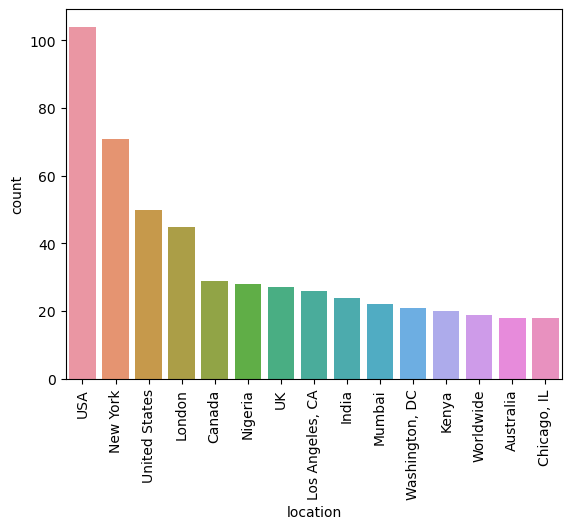

In [19]:
sns.countplot(x=train["location"],order=train.location.value_counts().iloc[:15].index)
plt.xticks(rotation=90)

In [20]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
text_to_train=train.text[3]

In [22]:
def location(cols):
    location=cols[0]
    text=cols[1]
    if pd.notna(location):
        return location
    text=nlp(text)
    for word in text.ents :
        if word.label_ in ["GPE","LOC"]:
            return word.text
    return "Others"

In [23]:
train["location"]=train[["location","text"]].apply(location,axis=1)

In [24]:
def cleanLocation(x):
    if x == 'Others':
        return 'Others'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    else:
        return x

In [25]:
train["location"]=train["location"].apply(cleanLocation)

In [26]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1


In [27]:
location=train.location.unique().tolist()

In [28]:
len(location)

3026

In [29]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [30]:
# def extractInformation(text):
#     hashWords=[]
#     hash_seq="#(\w+)"
#     hash_count=0
#     text=re.findall(hash_seq,text)
#     for word in text:
#         hash_count+=1  
#         hashWords.append(str(word))
#     return hashWords
# hashtagWords=extractInformation("Hi this is a beatuiful morning #hot #sunny")

In [31]:
def extractInformation(text):
    hash_seq="#(\w+)"
    text=re.findall(hash_seq,text)
    if text==[]:
        return []
    return text
hashtagWords=extractInformation("Hi this is a beatuiful morning hot sunny")

In [32]:
def hashMod(text):
    words=[]
    for word in text:
        if word in keyword:
            words.append(word)
    if words is not []:
        return words
    if text==[]:
        return("None")
    if words is []:
        return text
    

In [33]:
train["HashtagWords"]=train["text"].apply(extractInformation)
train["HashtagWords"]=train["HashtagWords"].apply(hashMod)
train["HashTagSum"]=train["HashtagWords"].apply(lambda x:len(x))

In [34]:
def joinKeywords(text):
    return " ".join(text)
train["HashtagWords"]=train["HashtagWords"].apply(joinKeywords)

In [35]:
# x=train[train["target"]==1]["text"].apply(len)
# y=train[train["target"]==0]["text"].apply(len)
# print("Average length of real tweets are ",np.average(x),"\n Average length of fake tweets are ",np.average(y))

In [36]:
def mentionSearch(text):
    pattern="@(\w+)"
    text=re.findall(pattern,text)
    if text==[]:
        return ("None")
    return " ".join(text)
train["mention"]=train["text"].apply(mentionSearch)
# train["mention"].value_counts()

In [37]:
def sentimentInput(text):
    scores=sentiment.polarity_scores(text)
    return pd.Series([scores["neg"],scores["pos"],scores["neu"],scores["compound"]])
    # train["Negative"]=sentiment.polarity_scores(text)["neg"]
    # train["Neutral"]=sentiment.polarity_scores(text)["neu"]
    # train["Positive"]=sentiment.polarity_scores(text)["pos"]
    # train["Comp"]=sentiment.polarity_scores(text)["compound"]
train[["Negative","Neutral","Positive","Comp"]]=train["text"].apply(sentimentInput)

In [38]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp
1889,2715,crushed,#HAMont,Edwin wow. Crushed.,0,,0,None,0.368,0.500,0.132,0.2500
506,731,attacked,Arundel,Christian Attacked by Muslims at the Temple Mo...,1,,0,None,0.158,0.000,0.842,-0.4588
7220,10339,weapons,"Houston, TX",I'm sorry but if you have to resort to weapons...,1,,0,None,0.334,0.191,0.475,-0.6486
3283,4709,epicentre,Others,Epicentre - Cydia Tweak - https://t.co/WKmfDig...,0,,0,phillipten,0.000,0.326,0.674,0.4404
156,222,airplane%20accident,Others,Pilot Dies In Plane Crash At Car Festival http...,1,,0,YouTube,0.123,0.146,0.731,0.1280
3606,5148,fatal,Also follow ?,Boy 11 charged with manslaughter in shooting d...,1,,0,None,0.363,0.000,0.637,-0.6908
3242,4658,engulfed,Others,Men escape car engulfed in flames in Parley's ...,1,,0,None,0.000,0.116,0.884,0.1779
4276,6074,heat%20wave,"Maricopa, AZ",@Startide It's hotter there than Phoenix this ...,0,,0,Startide,0.000,0.000,1.000,0.0000
468,677,attack,US,Police: Assailant in latest US movie theatre a...,1,,0,None,0.193,0.000,0.807,-0.4767
7566,10815,wrecked,USA,http://t.co/qVx0VQTPz0 Cramer: Iger's 3 words ...,0,,0,None,0.000,0.000,1.000,0.0000


In [39]:
train.corr()["target"].drop("target")

id            0.060781
HashTagSum    0.075032
Negative      0.124187
Neutral      -0.206829
Positive      0.030898
Comp         -0.220972
Name: target, dtype: float64

In [40]:
# text="You should less drink water and kill more people and stab them"
# scoresSentiment=sentiment.polarity_scores(text)
# scoresSentiment
# sentimentZero=train[train["SentimentScore"]==0]
# sentimentZero['target'].value_counts()
# sentimentNotZero=train[train["SentimentScore"]!=0]
# sentimentNotZero["target"].value_counts()
# sentimentGreaterThan5=(train["SentimentScore"]>0.25).sum()

In [41]:
train["HashtagWords"]=train["HashtagWords"].replace("","None")

In [42]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,0.851,0.2732
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,0.714,-0.3400
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,0.905,-0.2960
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,1.000,0.0000
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,1.000,0.0000


In [43]:
train["HashtagWords"].unique()

array(['earthquake', 'None', 'wildfires', 'flood disaster', 'flooding',
       'aftershock', 'accident', 'ambulance', 'apocalypse', 'armageddon',
       'bioterrorism', 'bombed', 'wildfire', 'casualties', 'catastrophe',
       'danger', 'dead', 'tragedy crash', 'floods', 'deluge',
       'demolished', 'survived', 'destruction', 'disaster', 'displaced',
       'drought', 'bomb', 'Earthquake', 'fire emergency rescue sirens',
       'evacuate', 'evacuation', 'fire', 'floods flooding', 'hailstorm',
       'hail hailstorm', 'hostages terrorism', 'terrorism', 'hurricane',
       'sinkhole landslide avalanche', 'landslide', 'lava', 'military',
       'disaster mudslide', 'mudslide', 'refugees', 'obliteration',
       'police', 'emergency', 'rainstorm landslide', 'drought wildfires',
       'rescued', 'seismic', 'sinkhole', 'sinking', 'storm', 'thunder',
       'Thunderstorm', 'thunder lightning thunderstorm', 'trauma',
       'survivors', 'traumatised', 'tsunami', 'whirlwind', 'fires',
      

In [44]:
def urlSearch(text):
    pattern=r"https?://t\.co/\S+"
    urls=re.findall(pattern,text)
    if urls:
        return " ".join(urls)
    else:
        return False
    

In [45]:
sample=urlSearch("Hi follow this url https://t.co/7MLMsUzV1Z")
sample

'https://t.co/7MLMsUzV1Z'

In [46]:
train["UrlCount"]=train["text"].apply(urlSearch)

In [47]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount
3716,5284,fear,Las Vegas,I want to be with you forever\nStay by my side...,0,None,0,None,0.244,0.156,0.600,-0.5385,False
4619,6567,injury,Others,FollowNFLNews: Michael Floyd's hand injury sho...,0,None,0,None,0.156,0.178,0.667,0.1027,http://t.co/5dUjGypImA
5168,7371,obliterate,Jump City,Dc I love you but please obliterate power girl,0,None,0,None,0.336,0.349,0.314,-0.2023,False
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,None,0,None,0.000,0.000,1.000,0.0000,http://t.co/3ImaomknnA
2023,2905,danger,Others,@BlizzHeroes @DustinBrowder DAD. I won't chase...,0,None,0,BlizzHeroes DustinBrowder,0.253,0.179,0.569,-0.3291,False
6646,9520,terrorist,Canada,You May Know Me from Such Roles as Terrorist #...,0,None,0,None,0.320,0.000,0.680,-0.6908,http://t.co/xImPncZXtH
2688,3857,detonation,Others,Detonation quotes - my esteemed belt quotes re...,0,None,0,None,0.000,0.209,0.791,0.4404,http://t.co/emzn4sPwNk
152,218,airplane%20accident,Others,This is unbelievably insane.\n#man #airport #a...,1,accident,1,None,0.200,0.000,0.800,-0.4576,https://t.co/cezhq7CzLl
4125,5864,hailstorm,Virgo Supercluster,This was Boston yesterday after an intense hai...,1,None,0,None,0.000,0.085,0.915,0.0772,http://t.co/8E6XuhrBKh http://t.co/Qo190N8UdD
7565,10814,wrecked,Others,Wrecked tired but not gonna be asleep before 3??,0,None,0,None,0.224,0.000,0.776,-0.3204,False


In [48]:
def clean_text(text):
    pattern1=r"https?://t\.co/\S+"
    pattern2=r"\d+"
    pattern3=r"@\w+"
    text=re.sub(pattern1,"",text)
    text=re.sub(pattern2,"",text)
    text=re.sub(pattern3,"",text)
    return text.strip()
clean_text("Hi this si a https://t.co/7MLMsUzV1Z 8980098 @return")

'Hi this si a'

In [49]:
train["cleaned_text"]=train["text"].apply(clean_text)

In [50]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,0.851,0.2732,False,Our Deeds are the Reason of this #earthquake M...
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,0.714,-0.3400,False,Forest fire near La Ronge Sask. Canada
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,0.905,-0.2960,False,All residents asked to 'shelter in place' are ...
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,1.000,0.0000,False,", people receive #wildfires evacuation orders ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,1.000,0.0000,False,Just got sent this photo from Ruby #Alaska as ...


In [51]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def grams(text):
    n=3
    text=word_tokenize(text)
    ngramsText=ngrams(text,n)
    return [" ".join(words) for words in ngramsText]

In [52]:
train["Trigrams"]=train["text"].apply(grams)

In [53]:
train.sample(5)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text,Trigrams
4867,6930,mass%20murderer,World,@NeanderRebel If you take the suit off him I w...,1,None,0,NeanderRebel,0.070,0.000,0.930,-0.1695,False,If you take the suit off him I wouldn't be sur...,"[@ NeanderRebel If, NeanderRebel If you, If yo..."
6358,9088,structural%20failure,Others,Investigators rule catastrophic structural fai...,1,None,0,None,0.394,0.000,0.606,-0.7579,http://t.co/Cy1LFeNyV8,Investigators rule catastrophic structural fai...,"[Investigators rule catastrophic, rule catastr..."
1871,2689,crush,Utah,Crush Content MarketingåÊMediocrity http://t.c...,0,None,0,None,0.286,0.000,0.714,-0.1531,http://t.co/IlQ0wQj0Xs http://t.co/aW1NYTpWJr,Crush Content MarketingåÊMediocrity,"[Crush Content MarketingåÊMediocrity, Content ..."
288,421,apocalypse,Others,RT: ZONEWolf123: I liked a YouTube video http:...,0,None,0,None,0.144,0.262,0.594,0.4574,http://t.co/u66kYg11ZD,RT: ZONEWolf: I liked a YouTube video Minecra...,"[RT : ZONEWolf123, : ZONEWolf123 :, ZONEWolf12..."
3497,4997,explosion,Florida,#Tampa: Super Freestyle Explosion Live in Conc...,0,None,0,None,0.000,0.301,0.699,0.6808,http://t.co/ooGotO76uZ,#Tampa: Super Freestyle Explosion Live in Conc...,"[# Tampa :, Tampa : Super, : Super Freestyle, ..."


In [54]:
train["Trigrams"]=train["Trigrams"]

In [55]:
text=train["Trigrams"][0]
text

['Our Deeds are',
 'Deeds are the',
 'are the Reason',
 'the Reason of',
 'Reason of this',
 'of this #',
 'this # earthquake',
 '# earthquake May',
 'earthquake May ALLAH',
 'May ALLAH Forgive',
 'ALLAH Forgive us',
 'Forgive us all']

In [56]:
def vectorize(text):
    vectors=[]
    for trigram in text:
        trigram=nlp(trigram)
        vectors.append(trigram.vector)  
    return vectors      

In [57]:
train.corr()["target"].drop("target").sort_values()

Comp         -0.220972
Neutral      -0.206829
Positive      0.030898
id            0.060781
HashTagSum    0.075032
Negative      0.124187
Name: target, dtype: float64

In [58]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,Positive,Comp,UrlCount,cleaned_text,Trigrams
3001,4312,dust%20storm,Lizzy's Knee,I keep sneezing either someone placed a southe...,0,None,0,None,0.000,0.000,1.000,0.0000,False,I keep sneezing either someone placed a southe...,"[I keep sneezing, keep sneezing either, sneezi..."
6115,8729,sinking,Others,Sinking carb consultative assembly plans could...,0,None,0,None,0.000,0.217,0.783,0.3818,False,Sinking carb consultative assembly plans could...,"[Sinking carb consultative, carb consultative ..."
108,158,aftershock,Instagram - @heyimginog,@afterShock_DeLo im speaking from someone that...,0,None,0,afterShock_DeLo,0.000,0.000,1.000,0.0000,False,im speaking from someone that is using a scuf ...,"[@ afterShock_DeLo im, afterShock_DeLo im spea..."
395,570,arson,"Eldoret, kenya",#Kisii Police in Kisii hunt for students over ...,1,None,0,None,0.155,0.000,0.845,-0.5106,http://t.co/m5SbFRrSn7,#Kisii Police in Kisii hunt for students over ...,"[# Kisii Police, Kisii Police in, Police in Ki..."
7361,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1,None,0,None,0.000,0.000,1.000,0.0000,http://t.co/JIOMnrCygT,Reality Training: Train falls off elevated tra...,"[Reality Training :, Training : Train, : Train..."
1122,1618,bombed,Others,Me trying to pass lax with my family ends up b...,0,None,0,None,0.000,0.000,1.000,0.0000,False,Me trying to pass lax with my family ends up b...,"[Me trying to, trying to pass, to pass lax, pa..."
1578,2279,cliff%20fall,Nigeria,When you're in deep sleep and then you dream y...,0,None,0,None,0.109,0.078,0.814,-0.2023,False,When you're in deep sleep and then you dream y...,"[When you 're, you 're in, 're in deep, in dee..."
6873,9854,trauma,Chicago,80 @UChicago faculty members pushing universit...,1,None,0,UChicago,0.409,0.000,0.591,-0.8074,http://t.co/ta1yqclpSc http://t.co/xToHI1HexY,faculty members pushing university to overturn...,"[80 @ UChicago, @ UChicago faculty, UChicago f..."
5066,7223,natural%20disaster,America of Founding Fathers,This is the natural and unavoidable consequenc...,1,None,0,None,0.000,0.152,0.848,0.3612,http://t.co/BbDpnj8XSx,This is the natural and unavoidable consequenc...,"[This is the, is the natural, the natural and,..."
3816,5423,first%20responders,Canada,What's cool is that teens are becoming what I ...,0,None,0,None,0.000,0.412,0.588,0.9067,False,What's cool is that teens are becoming what I ...,"[What 's cool, 's cool is, cool is that, is th..."


In [59]:
text="hello once again i am here to make work happen and once again i would like to thank you al"
def tags(text):
    text=nlp(text)
    for word in text:
        print(word.text ," ",spacy.explain(word.tag_))

In [60]:
def pos(text):
    text=nlp(text)
    oov=0
    noun=0
    adj=0
    adv=0
    verb=0
    punct=0
    det=0
    part=0
    pronoun=0
    conj=0
    prep=0
    interj=0
    num=0
    propernoun=0
    aux=0
    for word in text:
        if word.pos_ == "NOUN":
            noun+=1
        elif word.is_oov:
            oov+=1
        elif word.pos_ == "ADJ":
            adj+=1
        elif word.pos_ == "ADV":
            adv+=1
        elif word.pos_ == "VERB":
            verb+=1
        elif word.pos_ =="PUNCT":
            punct+=1
        elif word.pos_ =="DET":
            det+=1
        elif word.pos_ =="PART":
            part+=1
        elif word.pos_ =="PRON":
            pronoun+=1
        elif word.pos_ =="CONJ":
            conj+=1
        elif word.pos_ =="PREP":
            prep+=1
        elif word.pos_ =="INTERJ":
            interj+=1
        elif word.pos_ =="NUM":
            num+=1
        elif word.pos_ =="PROPN":
            propernoun+=1
        elif word.pos_ =="AUX":
            aux+=1

    return oov,noun,adj,adv,verb,punct,det,part,pronoun,conj,prep,interj,num,propernoun,aux

In [61]:
# oov,noun,adj,adv,verb,punct,det,part,pronoun,conj,prep,interj,num,propernoun,aux=pos(text)

In [62]:
train[["OutOfVocabulary", "Noun", "Adjective", "Adverb", "Verb", "Punctuation", "Deter", "Part","Pronoun","Conjunction","Prepositions","Interjections","NumericalNumbers","ProperN","Auxialry"]]=train["text"].apply(pos).apply(pd.Series)

In [63]:
train.sample(2)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
6687,9581,thunder,RT,Ebay Snipe RT? http://t.co/SlQnph34Nt Lego Pow...,0,None,0,None,0.000,0.377,...,4,0,0,0,0,0,0,0,12,0
1243,1791,buildings%20on%20fire,Nigeria,just in: #kenya: several buildings are reporte...,1,None,0,None,0.124,0.000,...,3,0,1,0,0,0,0,0,1,2


In [64]:
train["UrlCount"]=train["UrlCount"].apply(lambda x:1 if x!=False else 0)

In [65]:
train.sample(6)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
5398,7701,panicking,Others,New post: 'People are finally panicking about ...,0,None,0,None,0.244,0.000,...,3,0,0,0,0,0,0,0,0,1
6961,9986,tsunami,#ODU,@TSUNAMI_nopeach ?????? I'm weak af,0,None,0,TSUNAMI_nopeach,0.491,0.000,...,6,0,0,1,0,0,0,0,0,1
5115,7295,nuclear%20reactor,Others,Err:509,0,None,0,None,0.000,0.000,...,0,0,0,0,0,0,0,0,0,0
150,215,airplane%20accident,USA,@mickinyman @TheAtlantic That or they might be...,0,None,0,mickinyman TheAtlantic,0.337,0.131,...,2,3,0,3,0,0,0,0,0,3
6074,8677,sinkhole,Hinterestland,Sinkhole Selfies: You Wont Believe What's In T...,0,None,0,hinterestin,0.000,0.000,...,4,1,1,2,0,0,0,0,5,2
2621,3761,destruction,Moscow,Truck Driver Salvages Banned Tomatoes From Des...,0,None,0,None,0.401,0.000,...,0,0,0,0,0,0,0,0,3,0


In [66]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
dtype: object

In [67]:
# def clean_signs(text):
#     text=re.sub(r"[^a-zA-Z\s]","",text)
# train["keyword"]=train["keyword"].astype("str").apply(clean_signs)

<AxesSubplot:xlabel='UrlCount', ylabel='count'>

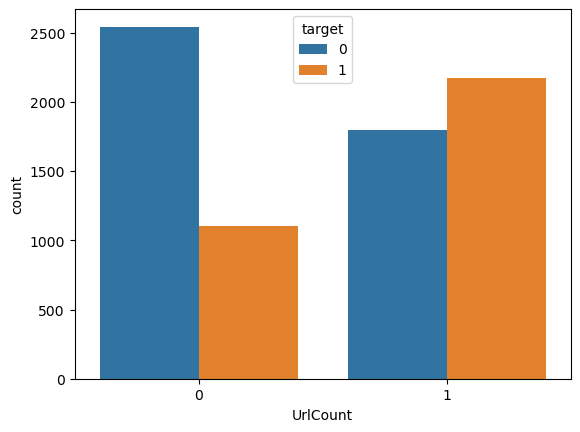

In [68]:
sns.countplot(x="UrlCount",data=train,hue="target")

<AxesSubplot:xlabel='HashTagSum', ylabel='count'>

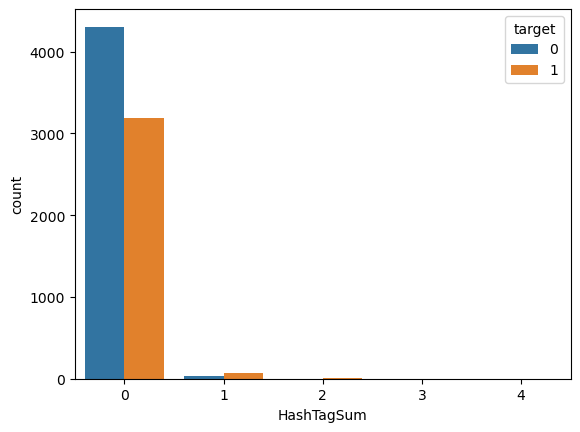

In [69]:
sns.countplot(x="HashTagSum",data=train,hue="target")

In [70]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Punctuation,Deter,Part,Pronoun,Conjunction,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,...,0,2,0,3,0,0,0,0,1,2
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,...,1,0,0,0,0,0,0,0,5,0
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,...,3,2,1,0,0,0,0,0,0,3
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,...,0,0,0,0,0,0,0,1,1,0
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,...,0,3,0,0,0,0,0,0,3,1


In [71]:
train.corr()["target"].drop("target")

id                  0.060781
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
normVectorize=TfidfVectorizer(analyzer="word")
trivectorize=TfidfVectorizer(ngram_range=(3,3))
CVectorize=CountVectorizer()

In [73]:
# train["text"]=train["text"].apply(lambda x:x.split())
# train["TextTFIDF"]=list(vectorize.fit_transform(train["text"].values).toarray())
# tfidf=tfidf.toarray()
# train["TextTFIDF"]=list(tfidf)
# train["hashVec"]=list(vectorize.fit_transform(train["HashtagWords"]).toarray())
# hashVec=hashVec.toarray()
# train["hastagWordsVec"]=list(hashVec)

In [74]:
# train.head()

In [75]:
trivectorize=TfidfVectorizer(ngram_range=(3,3))
CVectorize=CountVectorizer()
train["TextTFIDF"]=list(normVectorize.fit_transform(train["text"]).toarray())
train["hashVec"]=list(normVectorize.fit_transform(train["HashtagWords"]).toarray())
train["trigramTFIDF"]=list(trivectorize.fit_transform(train["text"]).toarray())
train["locationVec"]=list(CVectorize.fit_transform(train["location"]).toarray())
train["keyword"]=train["keyword"].astype("str")
train["keywordVec"]=list(CVectorize.fit_transform(train["keyword"]).toarray())
# trigramTFIDFarr=trigramTFIDF.toarray()
# train["TrigramsVec"]=list(trigramTFIDFarr)

In [76]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'HashtagWords',
       'HashTagSum', 'mention', 'Negative', 'Neutral', 'Positive', 'Comp',
       'UrlCount', 'cleaned_text', 'Trigrams', 'OutOfVocabulary', 'Noun',
       'Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
       'Pronoun', 'Conjunction', 'Prepositions', 'Interjections',
       'NumericalNumbers', 'ProperN', 'Auxialry', 'TextTFIDF', 'hashVec',
       'trigramTFIDF', 'locationVec', 'keywordVec'],
      dtype='object')

In [77]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,0.149,...,0,0,0,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,0.000,...,0,0,0,5,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,0.000,...,0,0,0,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,0.000,...,0,0,1,1,0,"[0.0, 0.41744665140268544, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,0.000,...,0,0,0,3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [78]:
locDataFrame=pd.DataFrame(train["location"])

In [79]:
locDataFrame.to_csv("LocValues.csv")

In [80]:
train.corr()["target"]

id                  0.060781
target              1.000000
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [81]:
train.sample(2)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
314,457,armageddon,Canada,@ENews Ben Affleck......I know there's a wife/...,0,None,0,ENews,0.114,0.212,...,0,0,0,3,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2871,4127,drought,Meereen,Pizza drought is over I just couldn't anymore...,0,None,0,None,0.000,0.000,...,0,0,0,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [82]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'HashtagWords',
       'HashTagSum', 'mention', 'Negative', 'Neutral', 'Positive', 'Comp',
       'UrlCount', 'cleaned_text', 'Trigrams', 'OutOfVocabulary', 'Noun',
       'Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
       'Pronoun', 'Conjunction', 'Prepositions', 'Interjections',
       'NumericalNumbers', 'ProperN', 'Auxialry', 'TextTFIDF', 'hashVec',
       'trigramTFIDF', 'locationVec', 'keywordVec'],
      dtype='object')

In [83]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
TextTFIDF            object
hashVec              object
trigramTFIDF         object
locationVec          object
keywordVec           object
dtype: object

In [84]:
train[["keyword", "location", "HashtagWords", "mention"]] = train[["keyword", "location", "HashtagWords", "mention"]].astype("str")


In [85]:
train.dtypes

id                    int64
keyword              object
location             object
text                 object
target                int64
HashtagWords         object
HashTagSum            int64
mention              object
Negative            float64
Neutral             float64
Positive            float64
Comp                float64
UrlCount              int64
cleaned_text         object
Trigrams             object
OutOfVocabulary       int64
Noun                  int64
Adjective             int64
Adverb                int64
Verb                  int64
Punctuation           int64
Deter                 int64
Part                  int64
Pronoun               int64
Conjunction           int64
Prepositions          int64
Interjections         int64
NumericalNumbers      int64
ProperN               int64
Auxialry              int64
TextTFIDF            object
hashVec              object
trigramTFIDF         object
locationVec          object
keywordVec           object
dtype: object

In [86]:
train.sample(8)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,Negative,Neutral,...,Prepositions,Interjections,NumericalNumbers,ProperN,Auxialry,TextTFIDF,hashVec,trigramTFIDF,locationVec,keywordVec
6829,9780,trapped,876 Jamrock.,Literally trapped in my room Cuz my bathroom b...,1,None,0,None,0.185,0.0,...,0,0,0,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4868,6931,mass%20murderer,"West Hollywood, CA",Has gun law ever dissuaded a potential mass mu...,1,None,0,None,0.538,0.0,...,0,0,0,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2858,4107,drought,Nigeria,w--=-=-=-[ NEMA warns Nigerians to prepare for...,1,None,0,None,0.149,0.0,...,0,0,0,2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1935,2783,curfew,Uganda,@DavisKawalya I know @Mauryn143 will be saying...,0,None,0,DavisKawalya Mauryn143,0.000,0.0,...,0,0,0,0,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1605,2317,collapse,Los Angeles,What would you do if you were trapped in a col...,0,None,0,None,0.268,0.0,...,0,0,0,0,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6080,8686,sinkhole,Newcastle,Sinkhole leaking sewage opens in housing estat...,1,None,0,None,0.000,0.0,...,0,0,1,2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
168,243,airplane%20accident,italy,airplane crashes on house in Colombia 12 peopl...,1,None,0,None,0.412,0.0,...,0,0,1,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3143,4517,emergency,Kuwait,Plane from New York to Kuwait diverts to UK af...,1,None,0,None,0.157,0.0,...,0,0,0,4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [87]:
train=train.drop(columns=["id","TextTFIDF","hashVec","trigramTFIDF","cleaned_text","Trigrams","locationVec","keywordVec"])

In [98]:
train.corr()["target"]

target              1.000000
HashTagSum          0.075032
Negative            0.124187
Neutral            -0.206829
Positive            0.030898
Comp               -0.220972
UrlCount            0.247134
OutOfVocabulary     0.038573
Noun                0.164720
Adjective           0.038008
Adverb             -0.113162
Verb               -0.047843
Punctuation        -0.038542
Deter              -0.028813
Part               -0.079962
Pronoun            -0.243012
Conjunction              NaN
Prepositions             NaN
Interjections            NaN
NumericalNumbers    0.107651
ProperN             0.124604
Auxialry           -0.118793
Name: target, dtype: float64

In [101]:
x=train.drop(columns="target")
y=train["target"]

In [102]:
x.columns

Index(['keyword', 'location', 'text', 'HashtagWords', 'mention', 'Negative',
       'Neutral', 'Comp', 'UrlCount', 'Noun', 'Adverb', 'Pronoun',
       'NumericalNumbers', 'ProperN', 'Auxialry'],
      dtype='object')

In [100]:
train=train.drop(columns=["HashTagSum","Positive","OutOfVocabulary","Adjective","Verb","Punctuation","Deter","Part","Conjunction","Prepositions","Interjections"])

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
normVectorizePipeline=Pipeline([
    ("normVectorizer",CountVectorizer())
])
TrigramVectorizePipeline=Pipeline([
    ("trigramVectorizer",TfidfVectorizer(ngram_range=(3,3)))
])
scaler=Pipeline([
    ("scale",StandardScaler())
])
normList=["keyword","location"]
scaleList=['Noun', 'Adverb','Pronoun','NumericalNumbers', 'ProperN', 'Auxialry']
preprocessor=ColumnTransformer(
    transformers=[
        ("norm",normVectorizePipeline,"keyword"),
        ("norm1",normVectorizePipeline,"location"),
        ("norm2",normVectorizePipeline,"HashtagWords"),
        ("norm3",normVectorizePipeline,"mention"),
        ("trigram",TrigramVectorizePipeline,"text"),
        ("scale",scaler,scaleList)
    ]
)
pipeline=Pipeline([
    ("finalPipeline",preprocessor)
])
X=pipeline.fit_transform(x)

In [105]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# normVectorizePipeline=Pipeline([
#     ("normVectorizer",CountVectorizer())
# ])
# TrigramVectorizePipeline=Pipeline([
#     ("trigramVectorizer",TfidfVectorizer(ngram_range=(3,3)))
# ])
# scaler=Pipeline([
#     ("scale",StandardScaler())
# ])
# normList=["keyword","location"]
# scaleList=['OutOfVocabulary', 'Noun','Adjective', 'Adverb', 'Verb', 'Punctuation', 'Deter', 'Part',
#        'Pronoun', 'Conjunction', 'Prepositions', 'Interjections','NumericalNumbers', 'ProperN', 'Auxialry']
# preprocessor=ColumnTransformer(
#     transformers=[
#         ("norm",normVectorizePipeline,"keyword"),
#         ("norm1",normVectorizePipeline,"location"),
#         ("norm2",normVectorizePipeline,"HashtagWords"),
#         ("norm3",normVectorizePipeline,"mention"),
#         ("trigram",TrigramVectorizePipeline,"text"),
#         ("scale",scaler,scaleList)
#     ]
# )
# pipeline=Pipeline([
#     ("finalPipeline",preprocessor)
# ])
# X=pipeline.fit_transform(x)

In [106]:
train.columns

Index(['keyword', 'location', 'text', 'target', 'HashtagWords', 'mention',
       'Negative', 'Neutral', 'Comp', 'UrlCount', 'Noun', 'Adverb', 'Pronoun',
       'NumericalNumbers', 'ProperN', 'Auxialry'],
      dtype='object')

In [107]:
X=X.toarray()

In [110]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y)

In [111]:
# from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
# sss=StratifiedShuffleSplit(n_splits=5,test_size=0.25)
# skf=StratifiedKFold(n_splits=5)
# for train_index,test_index in sss.split(X,y):
#     x_train,x_test=X[train_index],X[test_index]
#     y_train,y_test=y[train_index],y[test_index]

In [112]:
y_test.shape

(1904,)

In [114]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model=GaussianNB()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("Gaussian Naive Bayes")
print(classification_report(y_pred,y_test))

model=RandomForestClassifier(n_estimators=100,max_depth=100)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("Random Forest")
print(classification_report(y_pred,y_test))

print("Logistic Regression")
model=LogisticRegression()#(max_iter=200)#,penalty="elasticnet",solver="saga",l1_ratio=0.9)
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
print("Logistic Regression")
print(classification_report(y_pred,y_test))

Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.38      0.73      0.50       574
           1       0.81      0.50      0.62      1330

    accuracy                           0.57      1904
   macro avg       0.60      0.61      0.56      1904
weighted avg       0.68      0.57      0.58      1904

Random Forest
              precision    recall  f1-score   support

           0       0.97      0.67      0.80      1563
           1       0.38      0.91      0.53       341

    accuracy                           0.72      1904
   macro avg       0.68      0.79      0.67      1904
weighted avg       0.87      0.72      0.75      1904

Logistic Regression


c:\Users\25bak\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1169
           1       0.66      0.73      0.69       735

    accuracy                           0.75      1904
   macro avg       0.74      0.75      0.74      1904
weighted avg       0.76      0.75      0.75      1904

